# Tarea 1

Integrantes:
- Sara Sofía Rivera Sanabria.
- Juan Sebastián Rueda Segura.
- Santiago Rocha Pachón.

## Dependencias

In [1]:
!pip install matplotlib numpy

## Funciones auxiliares

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def graph_matrix(M: np.array, color_dict: dict) -> None:
    M = np.asarray(M)
    if M.ndim != 2:
        raise ValueError("M must be a 2D array")
    rows, cols = M.shape

    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_xticks(np.arange(0, cols))
    ax.set_yticks(np.arange(0, rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which="major", color="black", linewidth=1)
    ax.tick_params(length=0)

    cell_width_pts = (fig.get_figwidth() * 72) / max(cols, 1)
    cell_height_pts = (fig.get_figheight() * 72) / max(rows, 1)
    node_size = (0.35 * min(cell_width_pts, cell_height_pts)) ** 2

    for row in range(rows):
        for col in range(cols):
            value = M[row, col]
            if isinstance(value, np.generic):
                value = value.item()
            facecolor = color_dict[value]
            ax.scatter(col, row, s=node_size, c=facecolor, edgecolors="black", zorder=3)

    ax.set_aspect("equal")
    plt.show()


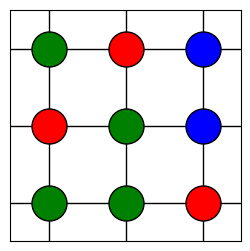

In [4]:
M: np.array = np.array([[1, 2, 3],
                        [2, 1, 3],
                        [1, 1, 2]])
color_dict: dict = {1: "green", 2: "red", 3: "blue"}
graph_matrix(M, color_dict)

## Modelo *hard-core*

### Introducción

Es un algoritmo diseñado para encontrar el número de posibles configuraciones de un grafo (o si se prefiere, la distribución de una cadena de Markov asociada) dado que cada vértice tiene un 'peso' o valor asociado de dos que puede tomar.

#### El espacio de configuración

Tiene las siguientes características:

- Un grafo $G = (V, E)$ con:
  - $|V| = n \times n$ vértices ($n \in \mathbb{N}^+$).
  - $|E| = 2 \cdot (n-1) \cdot n$ aristas que conectan los vértices de modo que se forme una 'grilla'.
- Cada vértice puede tomar algún valor de un conjunto $S$ con dos elementos. 
 
Un ejemplo se muestra en la imagen a continuación:

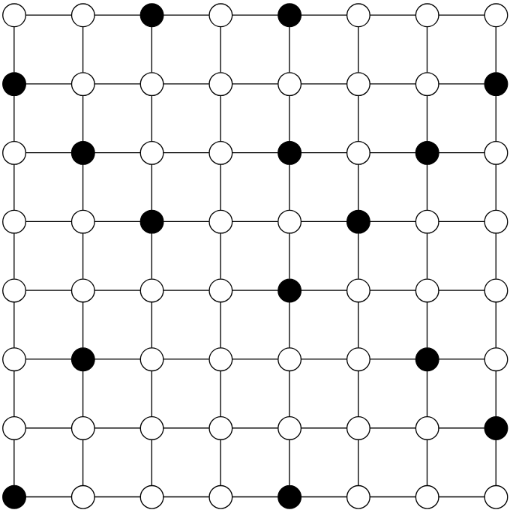

*Figura 1:* Modelo *hard-core* cuyo grafo asociado tiene $8 \times 8 = 64$ vértices y dos posibles 'colores' para cada vértice: blanco y negro.

En suma, es de interés saber cuáles configuraciones del grafo (i.e., asignándole a cada vértice ) son **factibles**. Estas son aquellas en las que, dado $S = \{b, w\}$, para todo vértice en $V$, si el vértice tiene valor asociado $b$, entonces ninguno de sus vecinos puede tener dicho valor asociado (es decir, todos sus vecinos deben tener valor $w$). De nuevo, un ejemplo de una configuración factible es la Figura 1.

> Nota: Sin pérdida de generalidad y siguiendo la mayoría de los textos que incluyen el modelo hard-core, $S$ será el conjunto $\{0, 1\}$, donde $1$ se representa como un vértice en negro y $0$ como un vértice en blanco.

#### El problema

El número de configuraciones posibles crece exponencialmente, pues, como cada vértice puede tener dos valores y hay $n^2$ de estos, habrán $2^{n^2}$ configuraciones posibles. Esto hace computacionalmente inviable inspeccionar si cada una de las configuraciones posibles es viable muy rápidamente a medida que se incrementa $n$.

¿Es ese el problema o es hallar una distribución estacionaria?

TODO: Consultar otras posibles formas de solucionar el problema.

#### La solución: una cadena de Markov

Si cualquiera de los valores de $S$ tiene la misma probabilidad de salir, y cada vértice puede ser escogido con la misma probabilidad, entonces cada una de las configuraciones factibles tendrá la misma probabilidad de salir si se asignan aleatorios (pero válidos) valores de $S$ a cada uno de los $n^2$ vértices. Además, de una configuración factible se puede llegar a otra alterando el valor de $S$ que tome un número de vértices menor a $|V| = n^2$.

Así pues, si se define un procedimiento capaz de ir de una configuración factible a otra tal que no hayan estados absorbentes, entonces se podrá diseñar una cadena de Markov irreducible y aperiódica cuya distribución estacionaria lucirá así:
$$
\mu_G(\eta) = 
\begin{cases}
\frac{1}{Z_G} & \text{si } \eta \text{ es una configuración factible.} \\
      0       & \text{en otro caso}
\end{cases}
$$
que es justamente lo que buscamos. De este modo, si se simula la cadena de Markov por un tiempo $t$ suficientemente grande, por el teorema de convergencia, $X_t \approx \pi$, y de este modo se podrá aproximar $Z_G$.

#### Primer paso: Muestrear $\mu_G$

Dicho procedimiento existe y es el siguiente: en el tiempo $n \in \mathbb{N}$,
1. Se elige un vértice $v \in V$ al azar (uniformemente).
2. Se lanza una moneda justa ($\mathbb{P}(C) = \mathbb{P}(S) = \frac{1}{2}$).
   1. Si sale cara, se pone un $1$ en $v$ ($X:{n + 1}(v) = 1$) si todos los vecinos de $v$ en la configuración de $X_n$ son $0$. De otro modo, se pone $0$ en $v$ ($X:{n + 1}(v) = 0$).
   2. Si sale sello, se pone $X:{n + 1}(v) = 0$ ($0$ en $v$ para la siguiente configuración).

Se vio en clase que esta distribución es reversible, aperiódica e irreducible, que era lo que necesitábamos. Ahora, se procederá a implementarlo.


### Implementación

In [191]:
import random
from typing import Iterable

import numpy as np

def determine_feasible_values(neighbors_values: list, S: list) -> list:
    neighs: set = list(set(neighbors_values))
    return [val for val in S if val not in neighs]

def get_neighbors_values(vertex: tuple, current_config: np.array) -> tuple:
    """Return values of all neighboo"""
    row: int = vertex[0]
    col: int = vertex[1]
    neighbors: list = []
    #*Left
    try:
        neighbors.append(current_config[row][col-1])
    except IndexError:
        pass
    #*Top
    try:
        neighbors.append(current_config[row-1][col])
    except IndexError:
        pass
    #*Right
    try:
        neighbors.append(current_config[row][col+1])
    except IndexError:
        pass
    #*Botttom
    try:
        neighbors.append(current_config[row+1][col])
    except IndexError:
        pass

    return neighbors

def count_n_of_x(config: list[list], x: any, S: list = ['w', 'b']) -> int:
    """
    Count the numbers of `x` in `config`, where `x` is an element of `S` and
    config is a lists of lists of elements of `S`
    """
    if x not in S:
        raise ValueError(f"x: {x} is not an element of S: {S}")
    
    count: int = 0
    for l in config:
        for y in l:
            if y == x:
                count+=1
                
    return count

def gibbs_sampler_hcm(k: int, initial_config: list[list], S: list = ['w', 'b'], n: int = 10000, print_each: int = 1000, verbose=False) -> list[list]:
    """
    Compute the $n$-th configuration value of a $k times k$ hard-core model using
    a Gibbs sampler that starts with an initial configuration `initial_config` 
    and updates it based on a uniform stationary distribution of the
    configurations which yields a fair-coin decision rule on which value to
    assign (from S) to each vertex. Also, it prints the current distribution
    every `print_each`.
    
    Parameters
    ----------
        k (int): A number such that `k`^2 is the number of vertices of the hard-core model to simulate.
        initial_distr (numpy.array): The initial configuration to start the simulation with. Must be a feasible configuration with `k`^2 entries.
        S (list): A list containing the unique possible values each vertex can take. The first one must be the one it can always take, and the second one the one we want no adjacent vertices of. Deafult is ['w', 'b'] for white and black, respectively.
        n (int, optional): The simulation will run up to step `n`. Default is 10000.
        print_each (int, optional): Every `print_each` simulations, the current distribution of the MCMC will be printed. Set it to 0 to run quietly. Default is 1000.
        verbose (bool, optional): Whether to print if a vertex cannot be updated due to the values of its neighbors.

    Returns
    -------
        numpy.array: An array of size $k^2$.
    """
    X: np.array = initial_config.copy()
    S_set: set = set(S)
    if len(set(S)) != len(S):
        raise Exception("a")
    for i in range(1, n + 1):
        #*1) Pick a vertex at random (but uniformly)
        rand1: int = random.randint(0, k*k - 1)
        vertex: tuple = (rand1 // k, rand1 % k)
        # print("Vertex:", vertex)

        #*2) Pick a random color from the uniform distribution of the possible colors vertex can take
        neighbors_vals: list = get_neighbors_values(vertex, X)
        feasible_values: list = determine_feasible_values(neighbors_vals, S)
        if S[0] not in feasible_values:
            feasible_values.append(S[0]) #*since 0 or white can always appear
        if len(feasible_values) == 0:
            if verbose:
                print(f"Neighbors have all {len(S)} values")
        else:
            rand2: int = random.randint(0, len(feasible_values) - 1)
            #*3) Update the chosen vertex according to the distribution and leave the rest unchanged
            X[vertex[0]][vertex[1]] = feasible_values[rand2]

        if print_each != 0:
            if i % print_each == 0:
                print(f"Config at time {print_each}: {X}")

    return X


> Note: S was left as a list to be able to preserve its order

The configuration has 16 particles out of 100


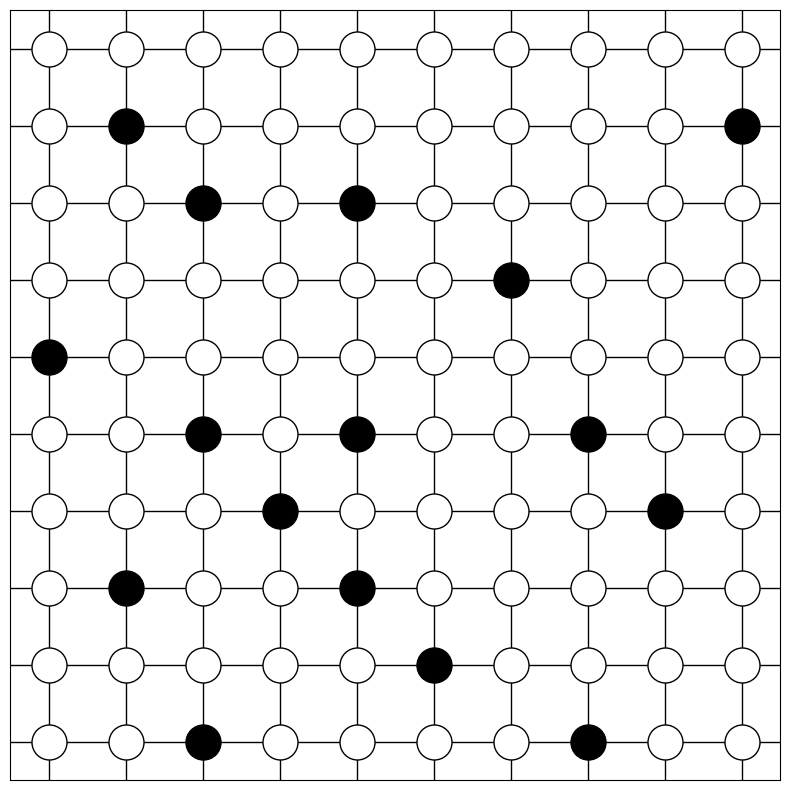

In [202]:
k: int = 10
X0: list[list] = [k * ['w'] for _ in range(k)]
S: list = ['w', 'b']
n: int = 100

final_config: list[list] = gibbs_sampler_hcm(k, initial_config=X0, S = S, n=n, print_each=0)
# print(final_config)
n_particles: int = count_n_of_x(final_config, "b", S)
print(f"The configuration has {n_particles} particles out of {k * k}")
graph_matrix(final_config, {"b": "black", "w": "white"})